# Session 4: homework

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update(
    {"mathtext.default": "regular", "figure.dpi": 300, "figure.figsize": (6, 6)}
)
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math

### 1. Arthurian manuscripts

Consider the following preprocessing steps (you get the code for free):
- load the Arthurian manuscripts metadata and restrict it to a subset of the columns
- Drop any incomplete rows.
- Only consider rows for which the script type is "cursive" or "textualis" (which are the most common script types)
- As in 4-2, drop entries with 'obvious' data entry issues
- Calculate the 'text_surface' (surface of the writing area) and 'leaf_surface' (surface of the full page) and assign these to new columns in the dataset (result in $cm^2$).

In [2]:
df = pd.read_csv("../datasets/arthur/manuscripts.csv", index_col=0)
df.columns = df.columns.str.replace("-", "_")

page_cols = ["leaf_height", "leaf_width", "text_height", "text_width"]
mss = df[
    page_cols
    + [
        "script",
        "material",
        "physical_type",
    ]
].dropna()
mss = mss[mss.script.isin(["textualis", "cursive"])]

# Divide by 10 for mm -> cm
mss[page_cols] = mss[page_cols].apply(lambda x: x / 10)

mss["text_area"] = mss.text_height * mss.text_width
mss["leaf_area"] = mss.leaf_height * mss.leaf_width

bad = (
    (mss.leaf_height < mss.text_height)
    | (mss.leaf_width < mss.text_width)
    | ((mss.leaf_area) < 0.001)
    | ((mss.text_area) < 0.001)
)
mss = mss[~bad]
mss

,leaf_height,leaf_width,text_height,text_width,script,material,physical_type,text_area,leaf_area
1,30.8,21.5,22.0,16.4,textualis,parchment,fragment,360.80,662.20
4,23.0,15.5,18.5,13.2,textualis,parchment,fragment,244.20,356.50
5,23.2,16.0,19.5,12.7,textualis,parchment,fragment,247.65,371.20
9,26.0,12.8,22.4,12.8,textualis,parchment,codex,286.72,332.80
28,30.5,23.5,23.6,17.6,textualis,parchment,codex,415.36,716.75
...,...,...,...,...,...,...,...,...,...
1138,23.5,15.5,18.8,12.8,cursive,parchment,fragment,240.64,364.25
1147,32.0,23.8,26.5,19.3,textualis,parchment,codex,511.45,761.60
1154,36.5,27.0,26.0,20.5,textualis,parchment,codex,533.00,985.50
1155,34.0,23.0,22.0,14.0,textualis,parchment,fragment,308.00,782.00


1. Run a univariate linear model in which you use a manuscript's `leaf_area` to predict its `text_area`. Print the model summary.

> CHECK What is the *dependent variable*? What is the **predictor**?

In [3]:
model = smf.ols("text_area ~ leaf_area", data=mss).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              text_area   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1022.
Date:                Sat, 12 Oct 2024   Prob (F-statistic):           2.17e-86
Time:                        22:04:27   Log-Likelihood:                -1307.5
No. Observations:                 231   AIC:                             2619.
Df Residuals:                     229   BIC:                             2626.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.2288     10.563      4.755      0.0

1. **FROM THE DATAFRAME** plot `leaf_area` vs `text_area` as a scatterplot with `sns.scatterplot`. Convention says that you should have the **dependent** variable on the y-axis, but either way, make sure the regression line seems to fit!

2. **MANUALLY** (not using `regplot` or seaborn tricks) add the regression line from the model parameters using `axline()` 

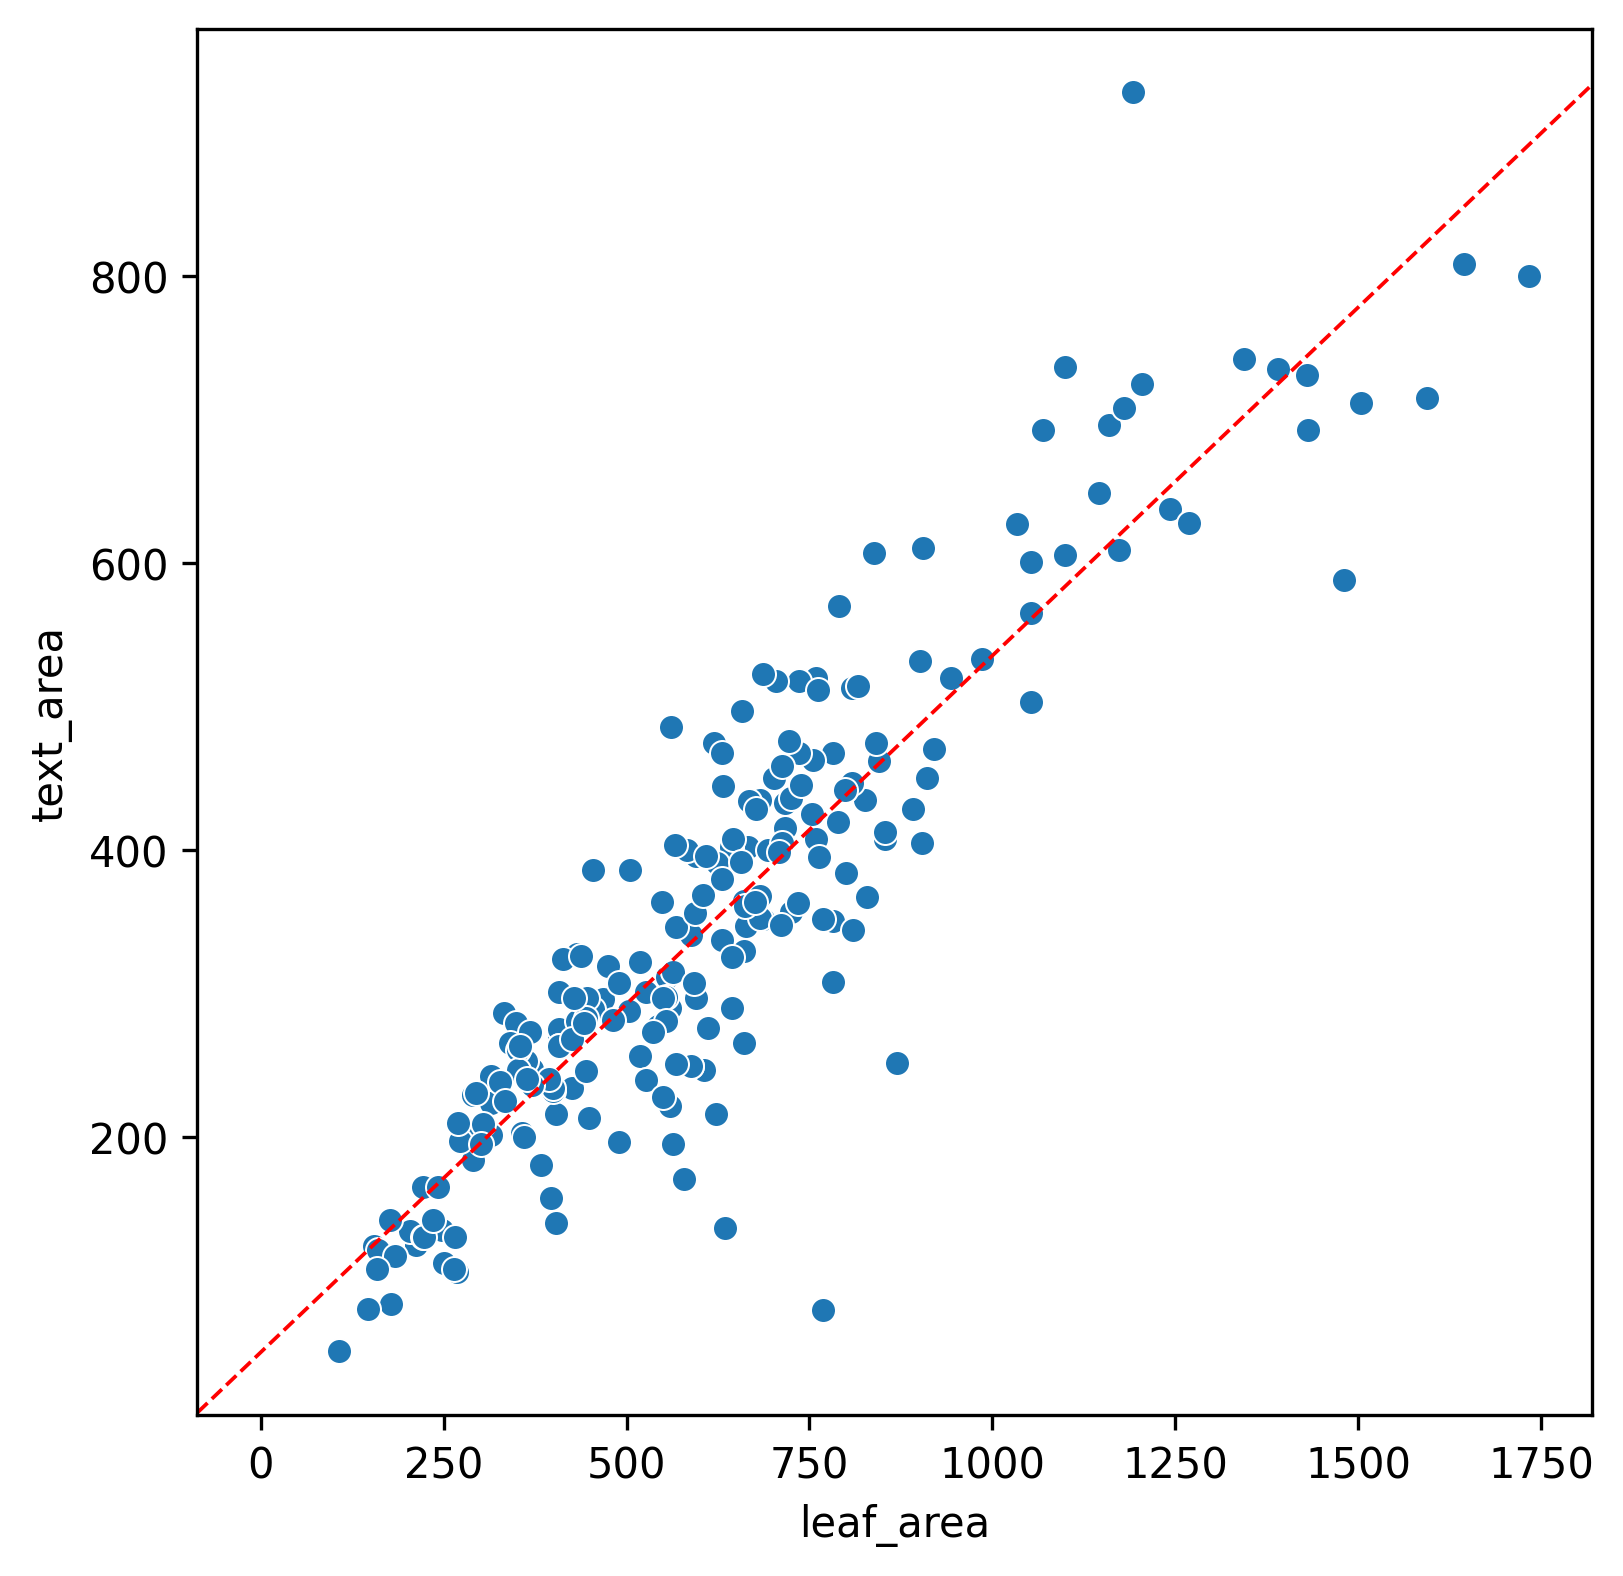

In [4]:
ax = sns.scatterplot(
    mss,
    x="leaf_area",
    y="text_area",
)
ax.axline(
    (0, model.params.Intercept),  # any (x,y) point on the line
    slope=model.params.leaf_area,  # slope, or any second point
    color="red",
    linestyle="--",
    linewidth=0.9,
)
plt.show()

Inspect the model to retrieve the estimated coefficients for the regression formula ($mx + c$). **Manually** (i.e. without a function call) calculate which `text_area` the model would propose for a manuscript with a `leaf_area` of 500 $cm^2$, 700 $cm^2$ and 1500 $cm^2$ respectively, by copying the coefficients into the formula for the regression line. Validate your result, by calling `predict()` on the model for all three cases simultaneously.

> TIP: This is a little fiddly. The easiest way for one variable is to pass a `dict` where the key is the predictor and the value is a `list` of values for which we want predictions. For multivariate models it will be easiest to pass a whole `DataFrame`

In [5]:
model.params

Intercept    50.228781
leaf_area     0.485339
dtype: float64

In [6]:
print(500 * model.params.leaf_area + model.params.Intercept)
print(700 * model.params.leaf_area + model.params.Intercept)
print(1500 * model.params.leaf_area + model.params.Intercept)

292.89813611201964
389.96587834907876
778.2368472973154


In [7]:
model.predict({"leaf_area": [500, 700, 1500]})

0    292.898136
1    389.965878
2    778.236847
dtype: float64

- Supplement the linear model which you just ran with the calculation of one of three correlation tests that we saw ("spearman", "kendall" or "pearson"). Justify your choice. Describe the correlation by looking up (*Gries, p. 147*) the suitable wording for the correlation coefficient which you obtain.

In [8]:
print(sp.stats.shapiro(mss.text_area))
print(sp.stats.shapiro(mss.leaf_area))

ShapiroResult(statistic=0.9581862456678228, pvalue=2.8886672141382284e-06)
ShapiroResult(statistic=0.9373359764486944, pvalue=2.2253701269507506e-08)


Both dimensions aren't normally distributed so pearson is out. Kendall's $\tau$ is a safer option (bc non-parametric); Spearman too (but it cannot deal well with ties). Stick with Kendall, since that is the least trouble in this case.

In [9]:
sp.stats.kendalltau(mss.text_area, mss.leaf_area)

SignificanceResult(statistic=0.7227093649730788, pvalue=6.81446111235751e-60)

The $\tau$ of $\sim$ 0.723 suggests a "very high positive correlation".

- Now, consider the following three categorical predictors (1) `physical_type`, (2) `script`, and (3) `material`. Run a separate `ols()` regression for each of these features as predictors for a manuscript's `leaf_area`. Provide an interpretation for each of the coefficients you obtain. Produce boxplots for each experiment.

                            OLS Regression Results                            
Dep. Variable:              leaf_area   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     4.011
Date:                Sat, 12 Oct 2024   Prob (F-statistic):             0.0464
Time:                        22:04:27   Log-Likelihood:                -1645.2
No. Observations:                 231   AIC:                             3294.
Df Residuals:                     229   BIC:                             3301.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

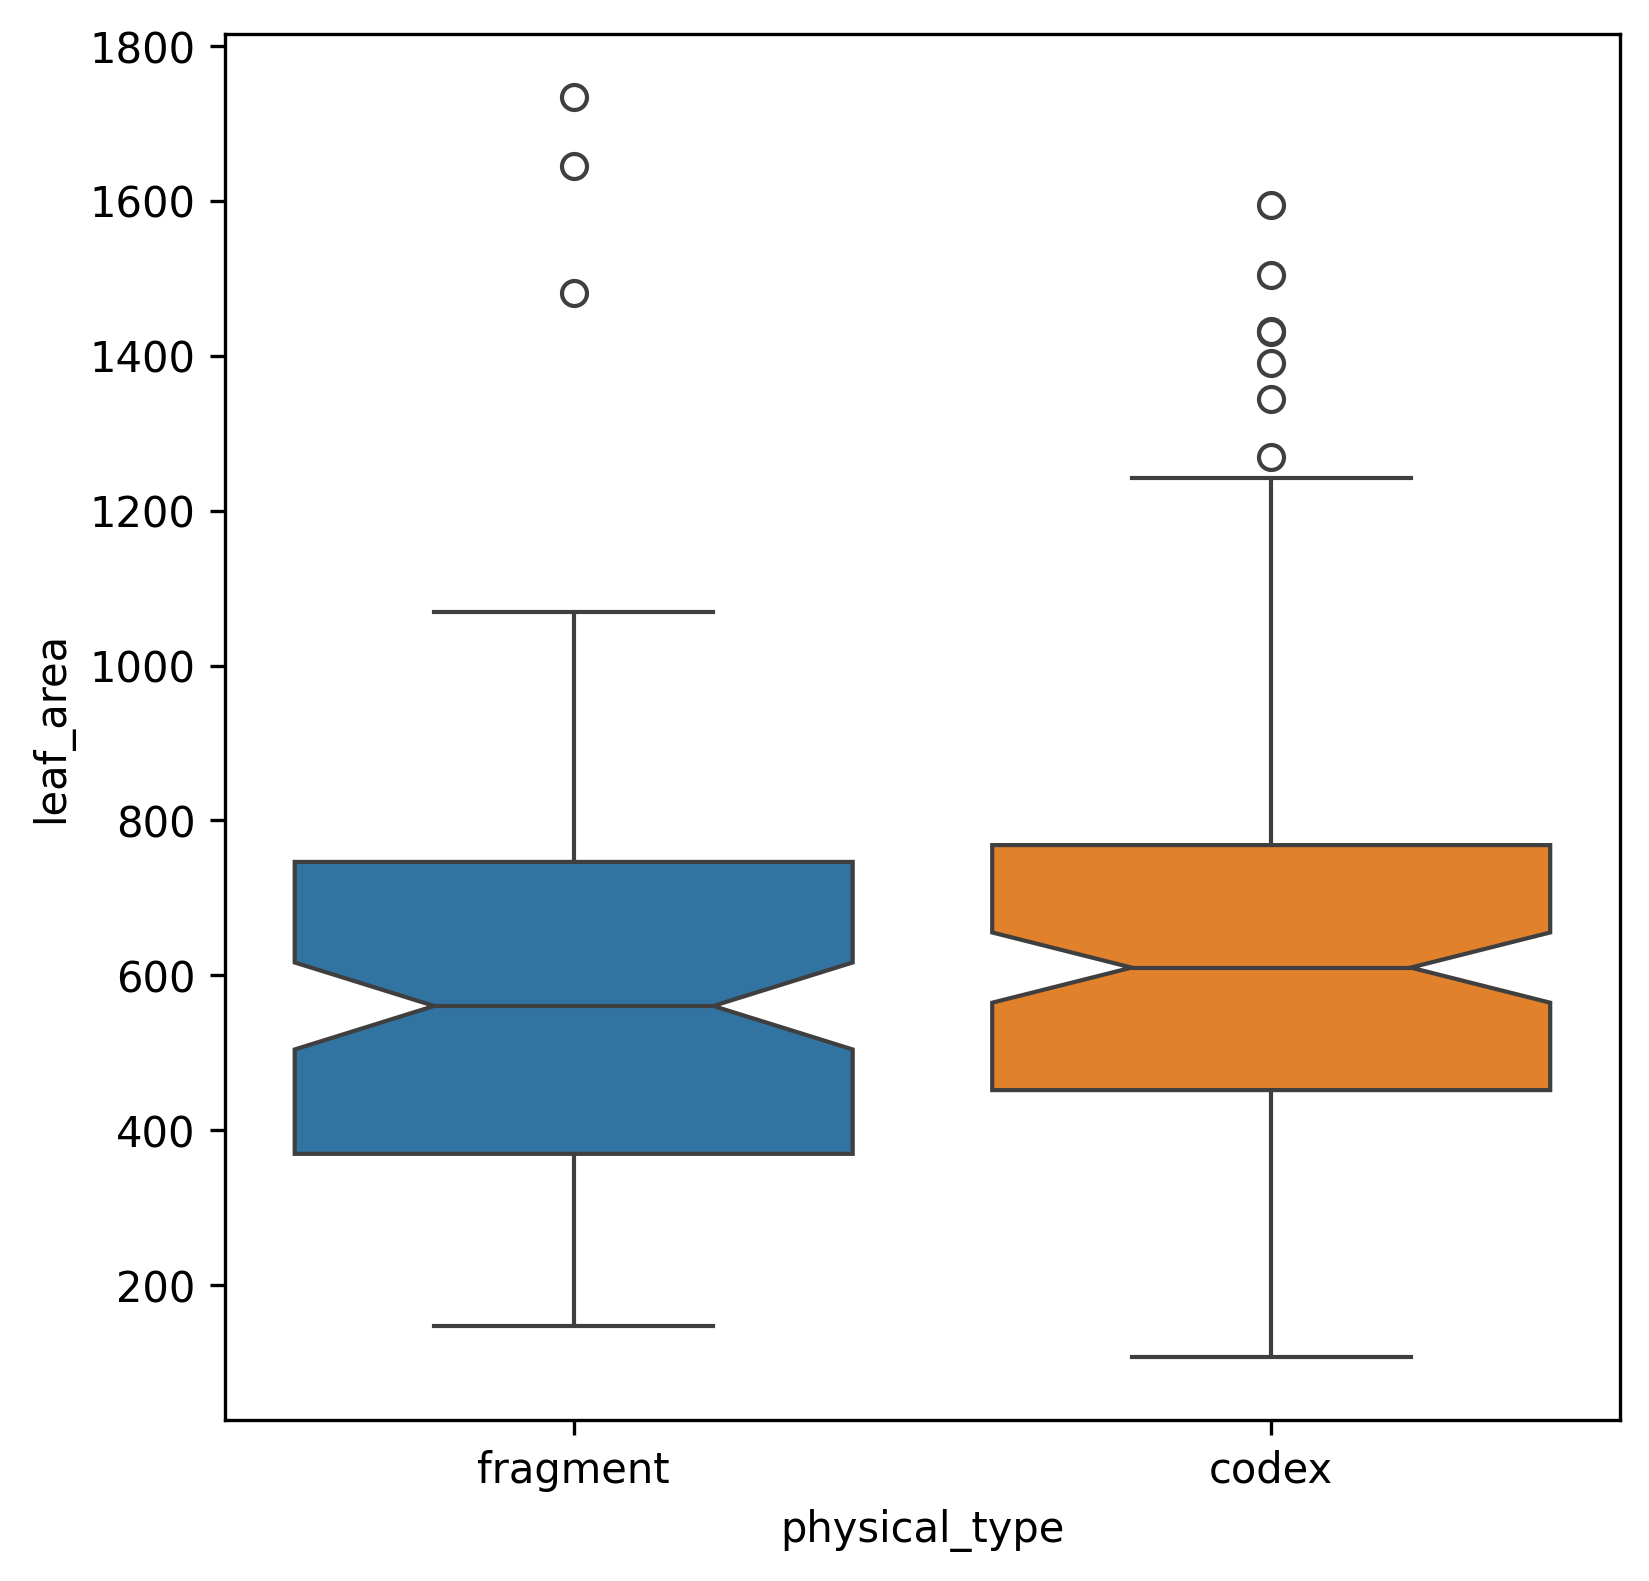

                            OLS Regression Results                            
Dep. Variable:              leaf_area   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.02450
Date:                Sat, 12 Oct 2024   Prob (F-statistic):              0.876
Time:                        22:04:27   Log-Likelihood:                -1647.2
No. Observations:                 231   AIC:                             3298.
Df Residuals:                     229   BIC:                             3305.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             619.6423    

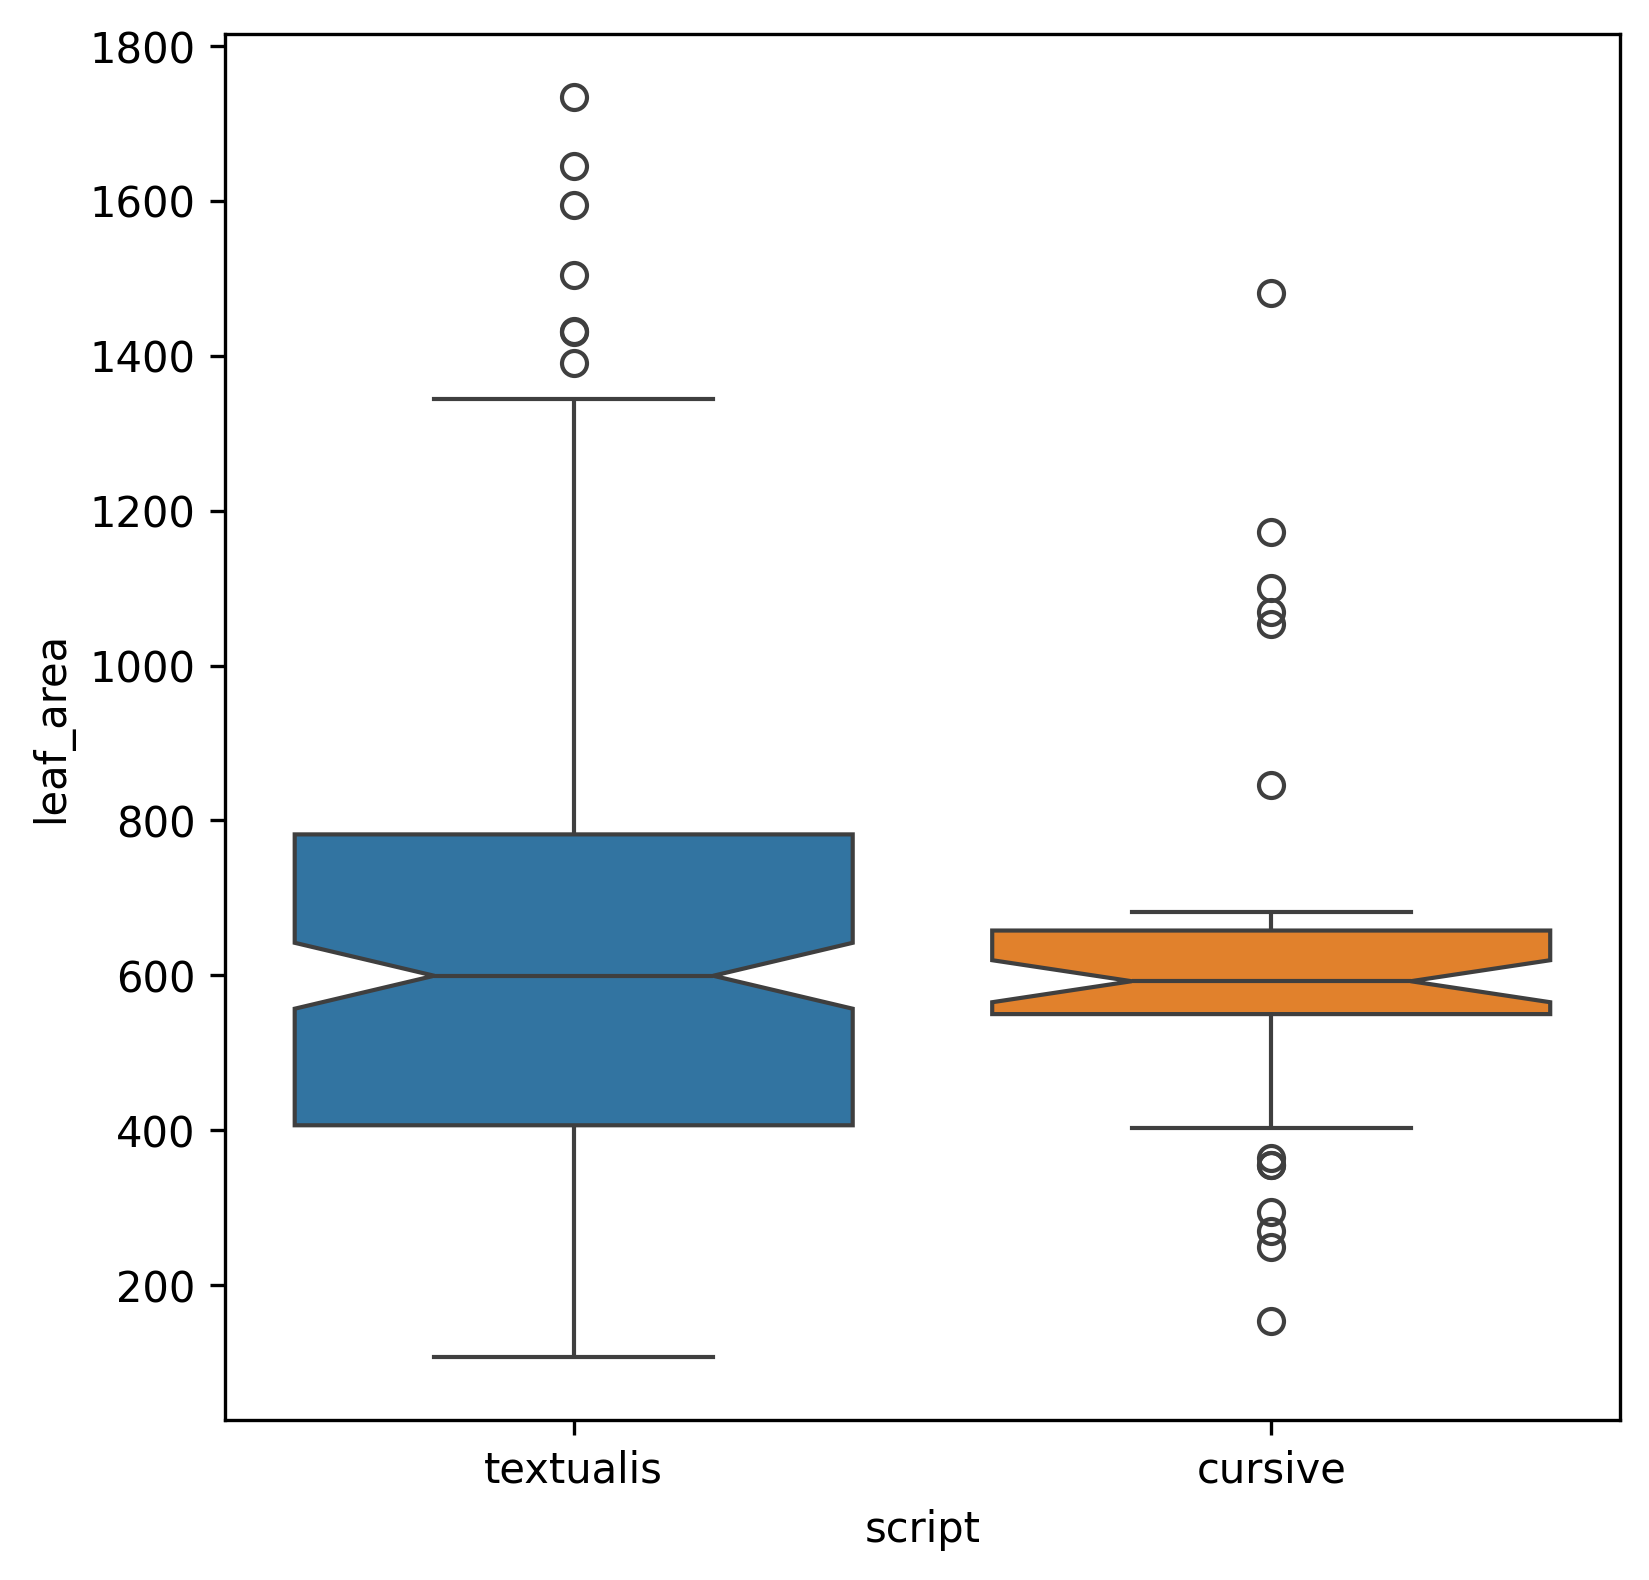

                            OLS Regression Results                            
Dep. Variable:              leaf_area   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.01108
Date:                Sat, 12 Oct 2024   Prob (F-statistic):              0.916
Time:                        22:04:28   Log-Likelihood:                -1647.2
No. Observations:                 231   AIC:                             3298.
Df Residuals:                     229   BIC:                             3305.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               631.92

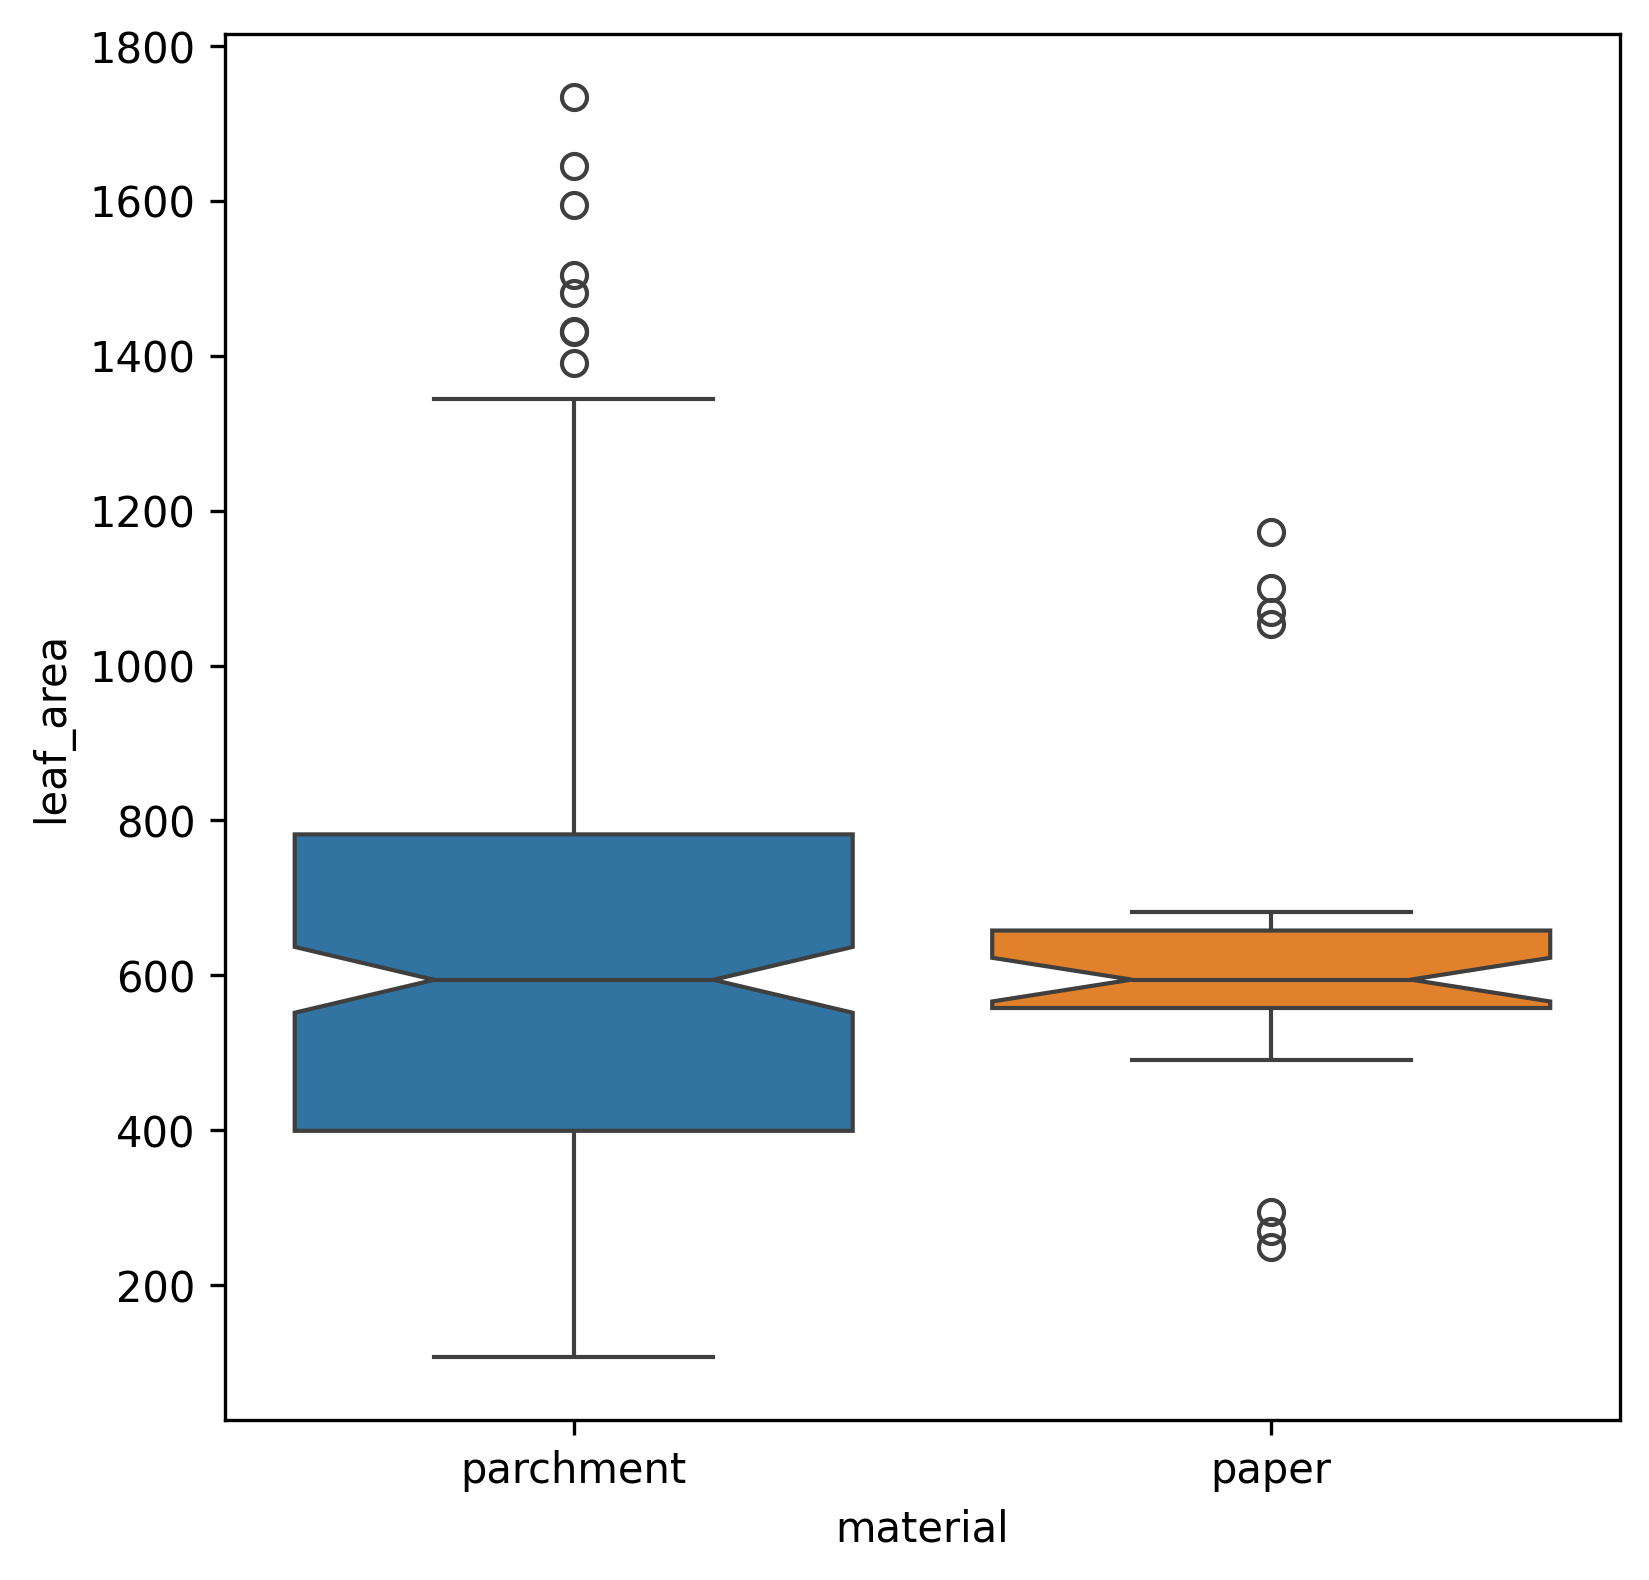

In [10]:
# THIS IS NOT A CODING COURSE... I am just very lazy

for predictor in ["physical_type", "script", "material"]:
    model = smf.ols(f"leaf_area ~ {predictor}", data=mss).fit()
    print(model.summary())
    sns.boxplot(data=mss, x=predictor, y="leaf_area", hue=predictor, notch=True)
    plt.show()

- On average, fragments are about 80 $cm^2$ smaller than intact codices. This coefficient is significant (barely) but the $R^2$ is tiny.
- For both the other models, we have a negative (adjusted) $R^2$, so they are not useful predictors
- From the boxplot we see that there is much less *spread* for paper manuscipts, which is interesting but not useful right now.


For obvious reasons, `leaf_area` is a good predictor for "text_area" (since they correlate), whereas `physical_type` also seems useful. Combine both `leaf_area` and `physical_type` as predictors into a single model that predicts `text_area`. Inspect whether and how the dependent variables complement each other. Compare the two single-variate models to the bivariate model. Which model would you prefer?

In [11]:
model = smf.ols("text_area ~ leaf_area + physical_type", data=mss).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              text_area   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     524.6
Date:                Sat, 12 Oct 2024   Prob (F-statistic):           4.90e-86
Time:                        22:04:28   Log-Likelihood:                -1304.6
No. Observations:                 231   AIC:                             2615.
Df Residuals:                     228   BIC:                             2625.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [12]:
model = smf.ols("text_area ~ leaf_area", data=mss).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              text_area   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1022.
Date:                Sat, 12 Oct 2024   Prob (F-statistic):           2.17e-86
Time:                        22:04:28   Log-Likelihood:                -1307.5
No. Observations:                 231   AIC:                             2619.
Df Residuals:                     229   BIC:                             2626.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.2288     10.563      4.755      0.0

In [13]:
model = smf.ols("text_area ~ physical_type", data=mss).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              text_area   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6119
Date:                Sat, 12 Oct 2024   Prob (F-statistic):              0.435
Time:                        22:04:28   Log-Likelihood:                -1503.3
No. Observations:                 231   AIC:                             3011.
Df Residuals:                     229   BIC:                             3017.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

> ANSWER

Adding `physical_type` as a predictor improves $R^2$, and lowers both the AIC and BIC. The coefficient itself is significant. We should probably keep it.

Note that it is not a useful predictor by itself!

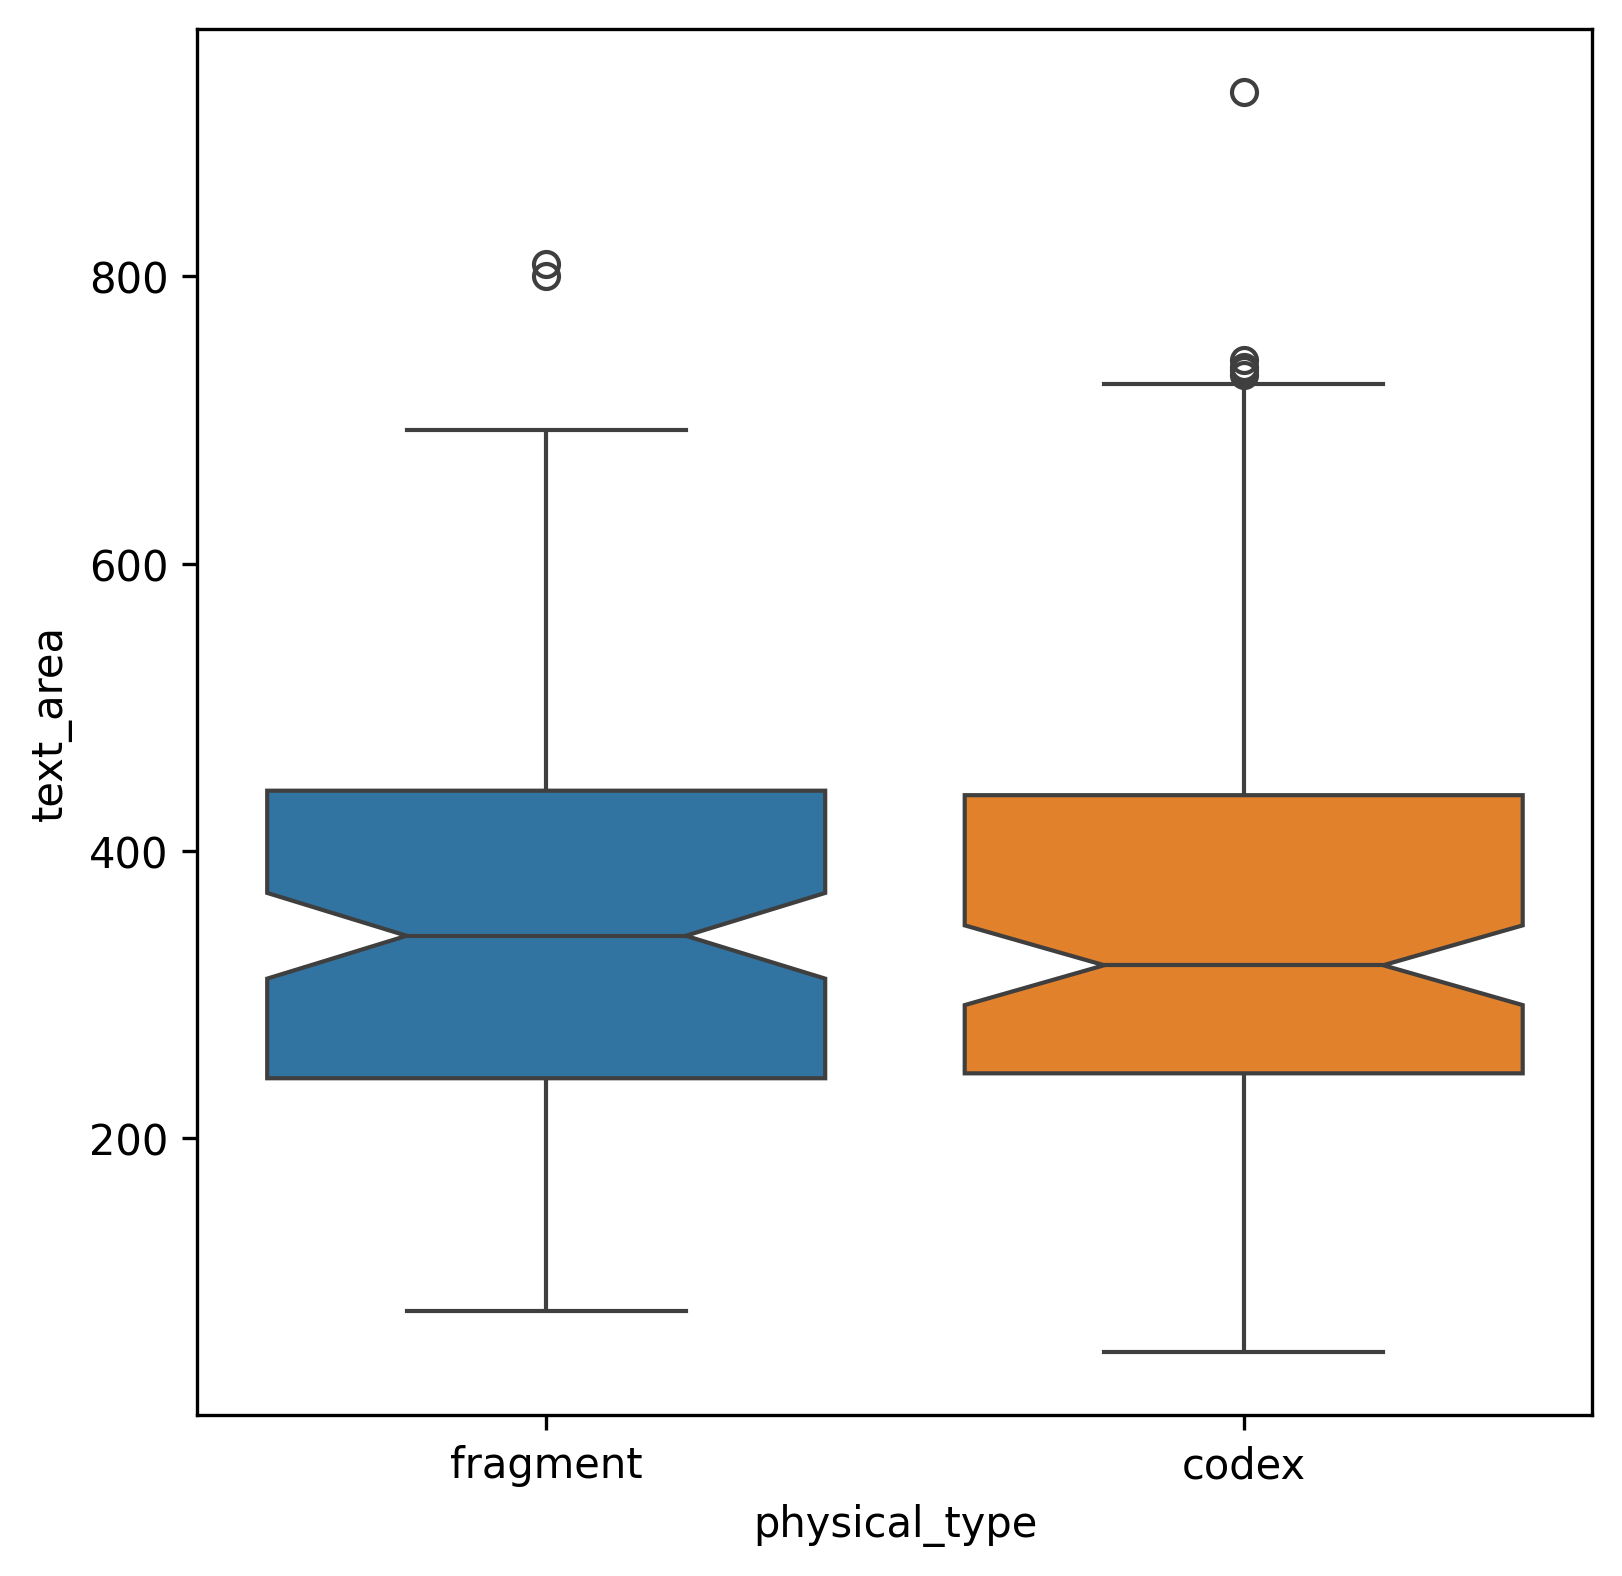

In [14]:
sns.boxplot(data=mss, x="physical_type", y="text_area", hue="physical_type", notch=True)
plt.show()

### 2. Harry Potter and the New Chapter

Reload the data on sentence lengths in the Harry Potter novels. Consider the UK sentence lengths and:
1. Produce a scatterplot in which you plot the sentence lengths in the UK chapters as a function of their (ascending) chapter index in this oeuvre.
- Provide a suitable title and descriptive labels for the horizontal and vertical axis.
2. Run a linear model and plot the regression line (in red) on top of the scatterplot. Report on the result of the linear model on the basis of the model's summary. Answer the question:
  - What is the average increase/decrease in tokens for every consecutive chapter in this series, according to this model?

In [15]:
hp = pd.read_csv("../datasets/potter/lengths.csv")
hp

,index,book,chapter,UK,US
0,1,1-Harry Potter and the Philosopher's Stone,00-The Boy Who Lived,20.989091,21.062044
1,2,1-Harry Potter and the Philosopher's Stone,01-The Vanishing Glass,21.505051,21.268657
2,3,1-Harry Potter and the Philosopher's Stone,02-The Letters from No One,19.738589,19.838174
3,4,1-Harry Potter and the Philosopher's Stone,03-The Keeper of the Keys,19.870968,19.846774
4,5,1-Harry Potter and the Philosopher's Stone,04-Diagon Alley,20.173302,19.911833
...,...,...,...,...,...
194,195,7-Harry Potter and the Deathly Hallows,32-The Prince’s Tale,21.755102,21.536437
195,196,7-Harry Potter and the Deathly Hallows,33-The Forest Again,20.284483,20.128205
196,197,7-Harry Potter and the Deathly Hallows,34-King’s Cross,19.057229,19.094225
197,198,7-Harry Potter and the Deathly Hallows,35-The Flaw in the Plan,27.484663,26.578635


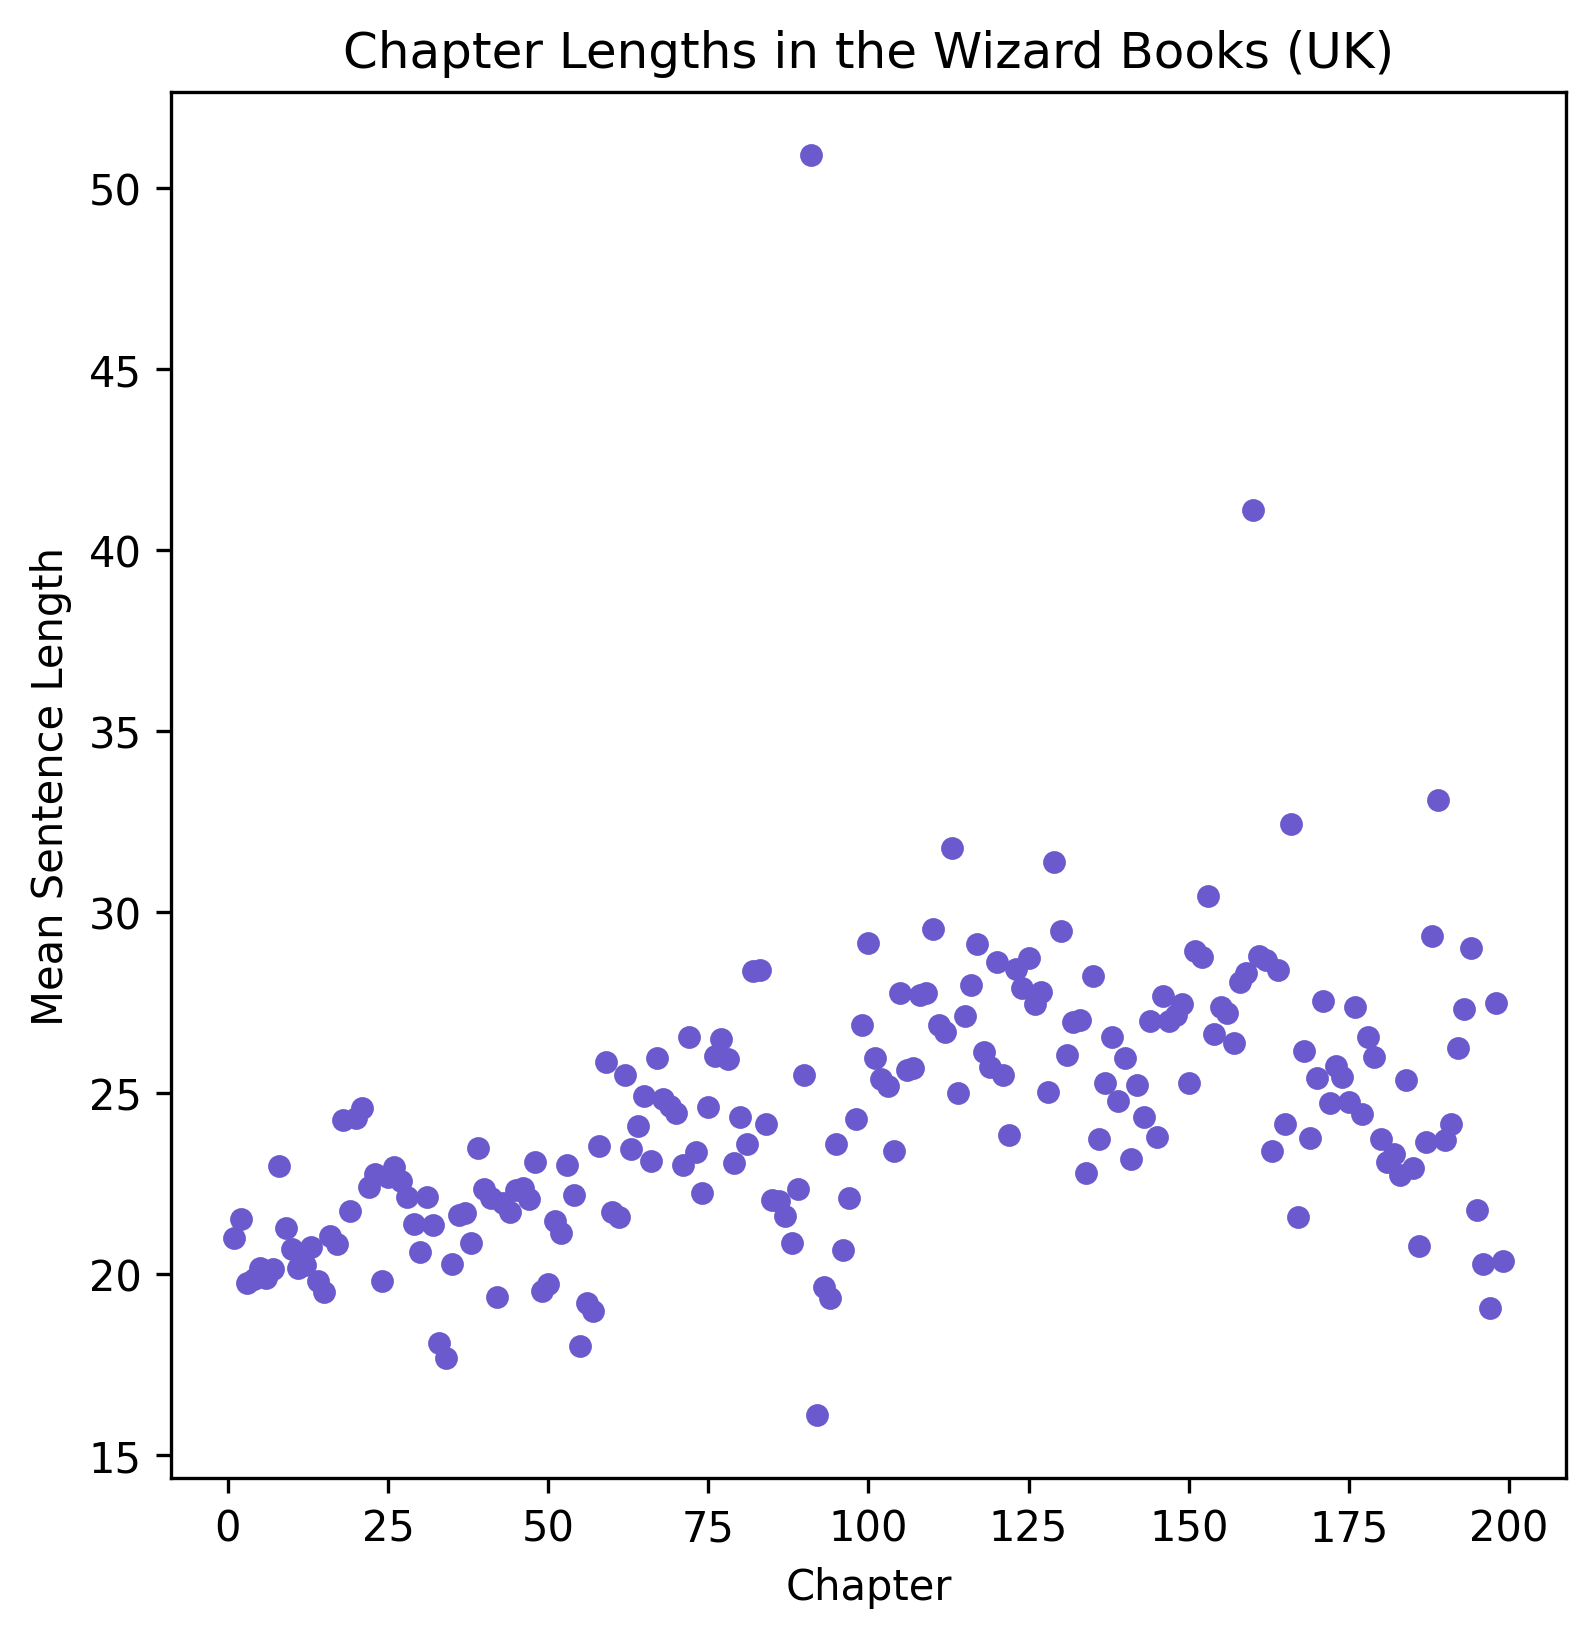

In [16]:
ax = hp.plot.scatter(x="index", y="UK", color="slateblue")
ax.set(
    xlabel="Chapter",
    ylabel="Mean Sentence Length",
    title="Chapter Lengths in the Wizard Books (UK)",
)
plt.show()

In [17]:
model = smf.ols("UK ~ index", data=hp).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     UK   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     54.36
Date:                Sat, 12 Oct 2024   Prob (F-statistic):           4.52e-12
Time:                        22:04:28   Log-Likelihood:                -525.86
No. Observations:                 199   AIC:                             1056.
Df Residuals:                     197   BIC:                             1062.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.3422      0.486     43.895      0.0

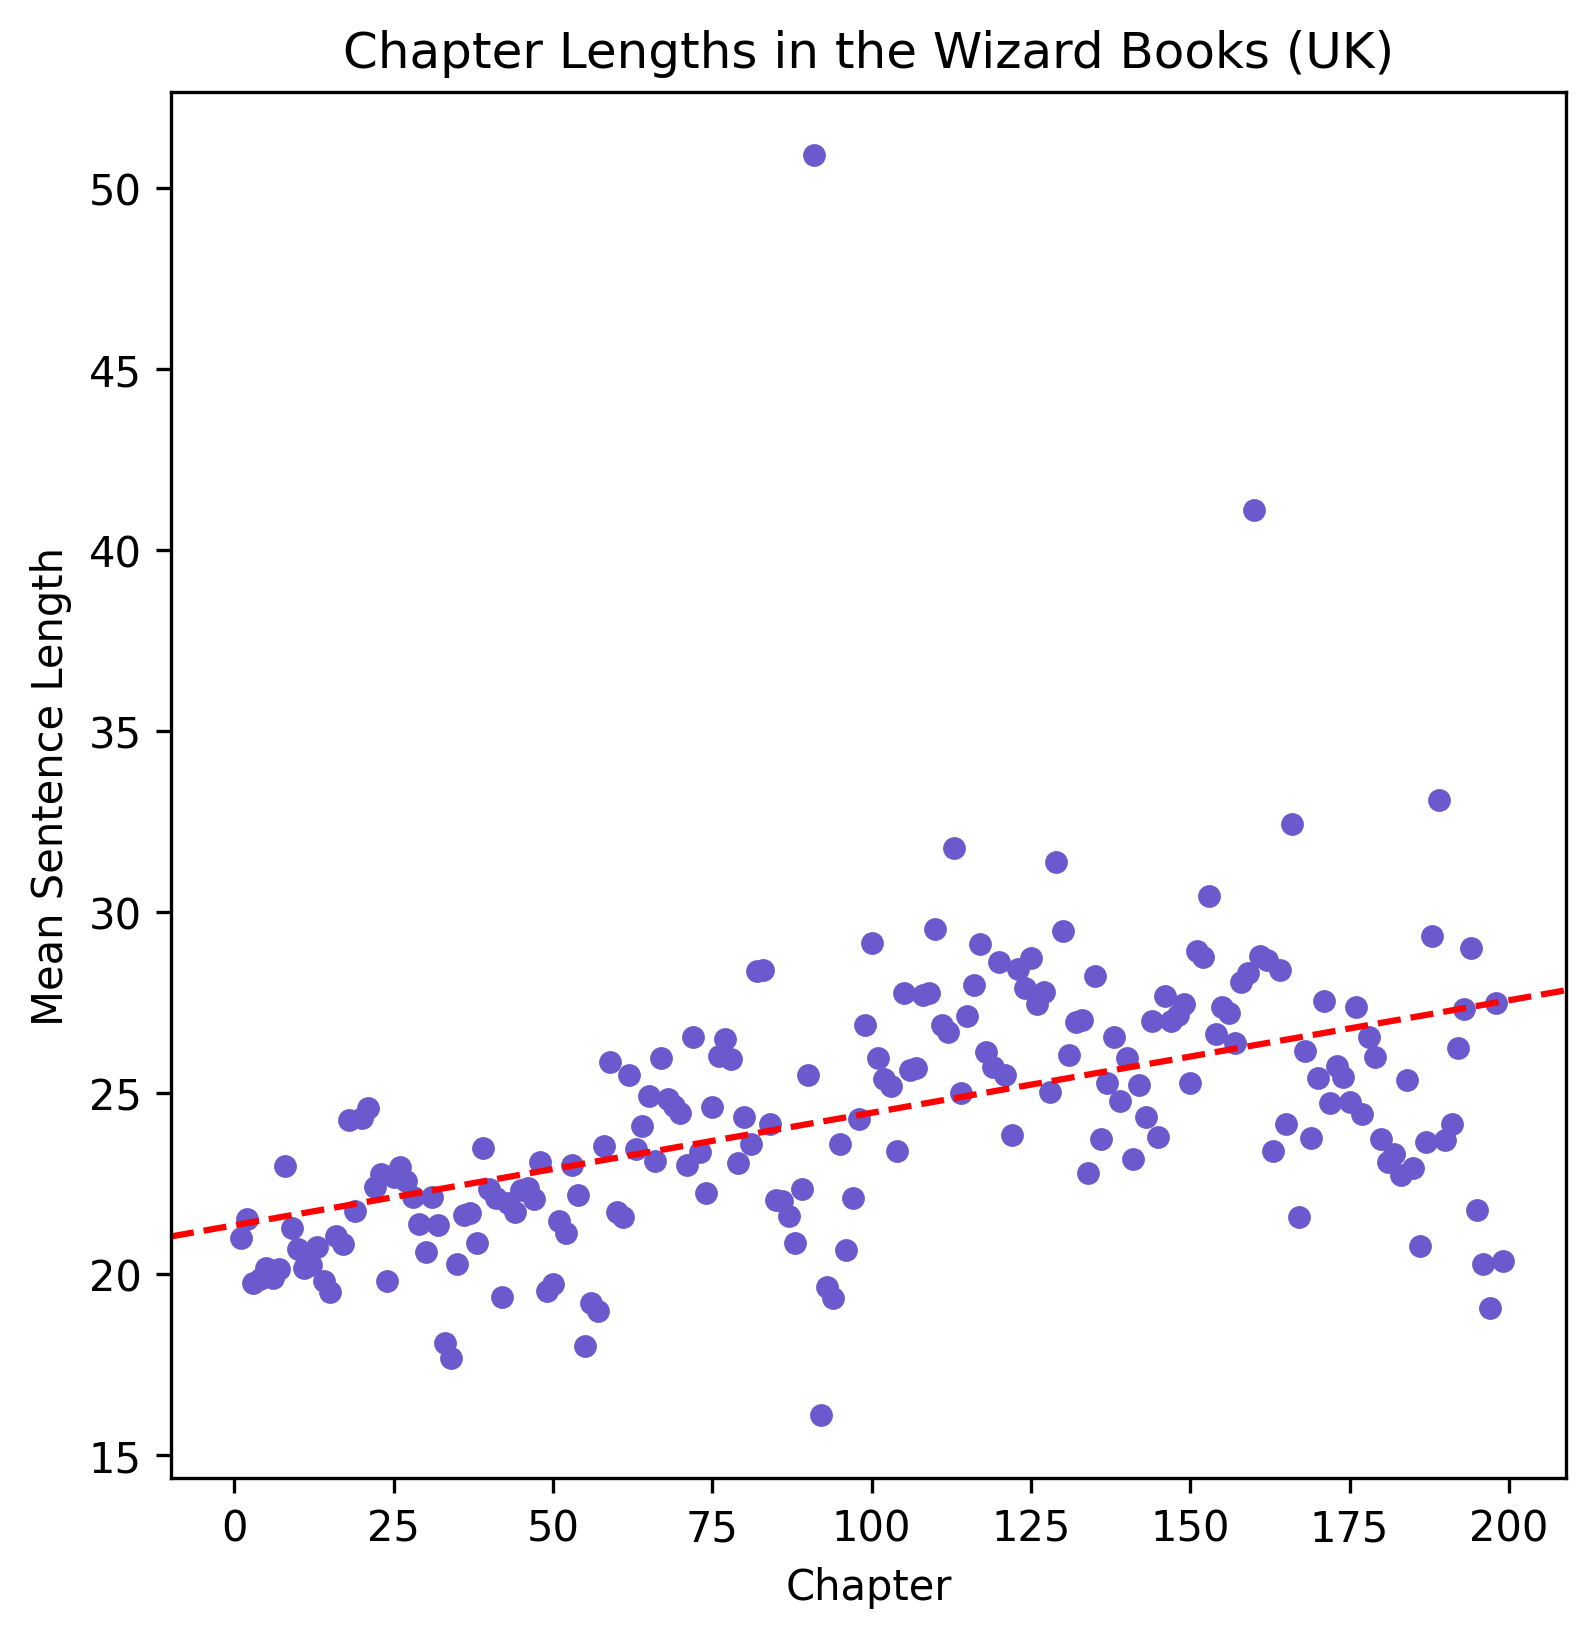

In [18]:
ax = hp.plot.scatter(x="index", y="UK", color="slateblue")
ax.set(
    xlabel="Chapter",
    ylabel="Mean Sentence Length",
    title="Chapter Lengths in the Wizard Books (UK)",
)
ax.axline(
    (0, model.params.Intercept),  # any (x,y) point on the line
    slope=model.params["index"],  # slope, or any second point
    color="red",
    linestyle="--",
)
plt.show()

> ANSWER

The average increase in chapter length is 0.031 (this is the coefficient of the `index` parameter), which is also the (positive) slope of the line


Finally, if a new chapter were produced at the end of the final book, use the statsmodels `get_prediction` API to predict its *mean length* with an associated 95% confidence interval.

In [19]:
model.get_prediction({"index": [200]}).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,27.558759,0.486213,26.599909,28.517609,20.753224,34.364294


> ANSWER: The mean prediction (the most likely) is $\sim 27.56$ words per sentence, but anything in the range $(26.6, 28.52)$ would be credible.

<img src=https://imgs.xkcd.com/comics/linear_regression.png>

<small>[XKCD](https://xkcd.com/1725/) CC-BY-NC 2.5</small>

```
Version History

Current: v1.0.0

8/10/24: 1.0.0: first draft, BN
9/10/24: 1.0.1: proofread, MK
```